In [1]:
%load_ext kedro.ipython
%matplotlib inline

[04/04/23 12:52:20] INFO     Resolved project path as: /home/eckt/Documents/usg.                    ]8;id=11407;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=312124;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[04/04/23 12:52:23] INFO     Kedro project usg                                                      ]8;id=996494;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=26143;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=857126;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=33279;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

[04/04/23 12:52:24] INFO     Registered line magic 'run_viz'                                        ]8;id=169027;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=684222;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#110\110]8;;\

In [2]:
import pandas as pd
import polars as pl
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt
import seaborn.objects as so
from seaborn.objects import Plot

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from kmodes.kprototypes import KPrototypes

import logging

from usg.utils import *

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
sb.set()

In [3]:
kaggle_steam: pd.DataFrame = catalog.load('kaggle_steam')
kaggle_steam.head()

                    INFO     Loading data from 'kaggle_steam' (CSVDataSet)...                   ]8;id=391883;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=273731;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


<Axes: xlabel='median_playtime'>

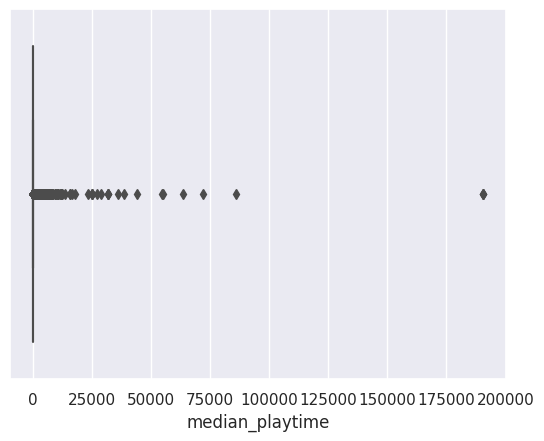

In [4]:
sb.boxplot(data=kaggle_steam, x="median_playtime")

In [5]:
kaggle_steam.shape

(27075, 18)

<Axes: xlabel='median_playtime', ylabel='Count'>

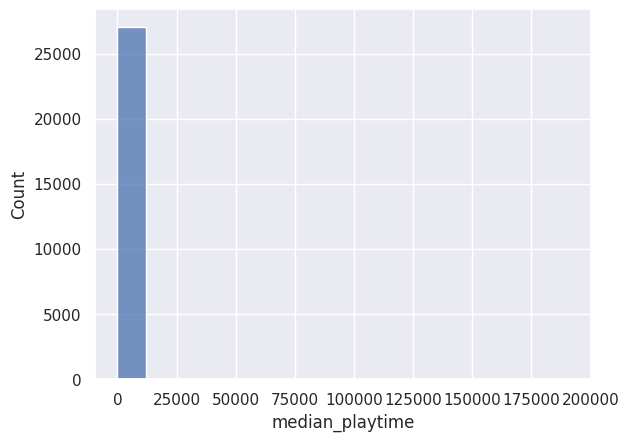

In [6]:
sb.histplot(data=kaggle_steam["median_playtime"])

<Axes: xlabel='median_playtime', ylabel='Count'>

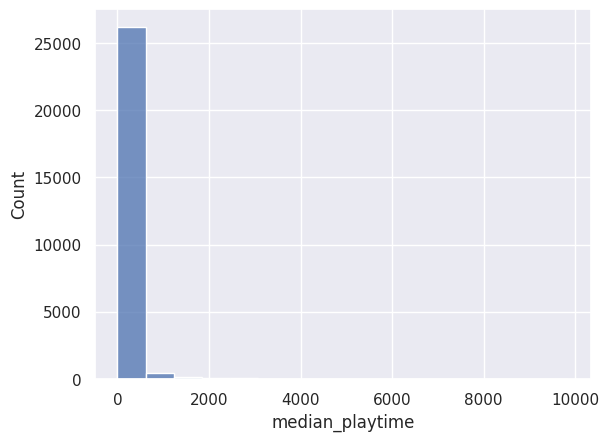

In [7]:
median_playtime = kaggle_steam['median_playtime']
sb.histplot(data=median_playtime.loc[(median_playtime < 10000)])

<Axes: xlabel='median_playtime', ylabel='Count'>

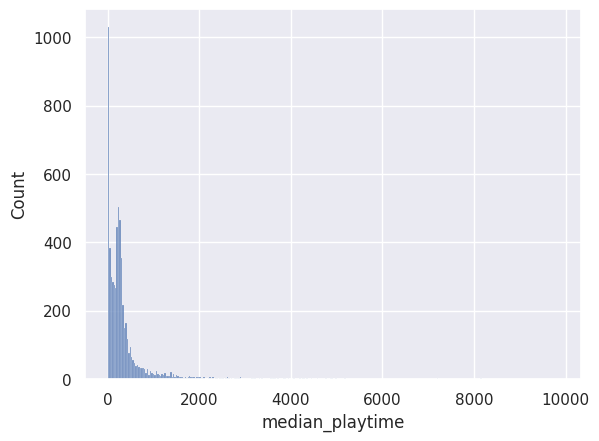

In [8]:
sb.histplot(data=median_playtime.loc[(0 < median_playtime) & (median_playtime < 10000)])

<Axes: >

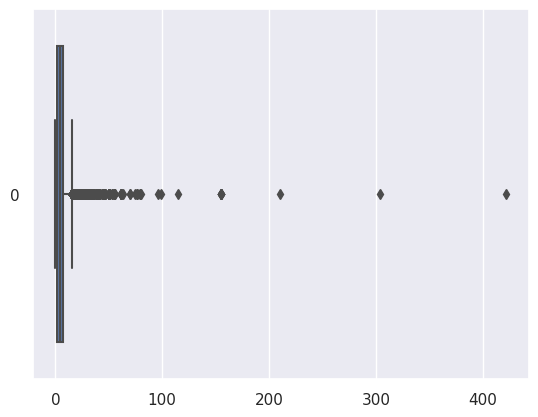

In [9]:
sb.boxplot(data=kaggle_steam['price'], orient='h')

<Axes: xlabel='price', ylabel='Count'>

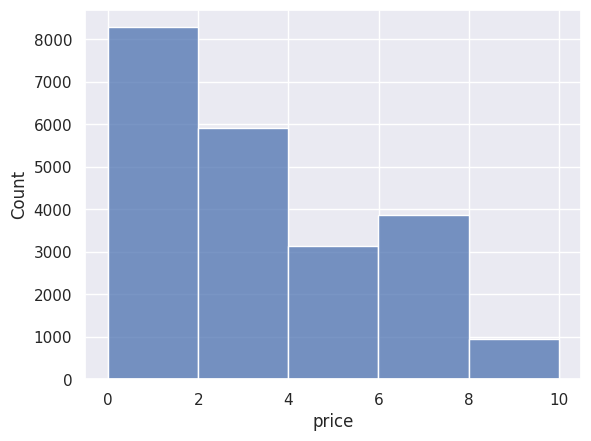

In [10]:
sb.histplot(data=kaggle_steam[kaggle_steam['price'] < 10], x='price', bins=5)

# Categorical variables analysis

The dataset has **11** categorical variables: `appid`, `name`, `release_date`, `english`, `developer`. `publisher`, `platforms`, `categories`, `genres`, `steamspy_tags` and `owners`.

In [11]:
kaggle_steam.dtypes

appid                 int64
name                 object
release_date         object
english               int64
developer            object
publisher            object
platforms            object
required_age          int64
categories           object
genres               object
steamspy_tags        object
achievements          int64
positive_ratings      int64
negative_ratings      int64
average_playtime      int64
median_playtime       int64
owners               object
price               float64
dtype: object

We will be examining the following categorical variables to see if we can use them for clustering.

- `release_date`
- `english`
- `platforms`
- `categories`
- `genres`
- `steamspy_tags`
- `owners`

We omitted:

- `app_id` as it is id value, it has no meaning,
- `name` is unique per record, hence has no meaning
- `developer` is immediately apparent to have many labels, it will increase dimensionality of our data too much and impact our model's performance
- `publisher` same as above

## Dealing with single-valued categorical variables.

We will first look at `release_date`, `english`, and `owners` as each of them only contains a single value per record.

### `release_date`

In [12]:
# Since dates are in YYYY-MM-dd format we can just take advantage of this and split on '-' to get the year.

kaggle_steam['year'] = kaggle_steam['release_date'].str.split('-').map(lambda x: int(x[0]))
kaggle_steam['year'].value_counts()

2018    8160
2017    6357
2016    4361
2015    2597
2019    2213
2014    1555
2013     418
2012     320
2009     305
2011     239
2010     238
2008     145
2007      93
2006      48
2005       6
2004       6
2001       4
2003       3
2000       2
1999       2
2002       1
1998       1
1997       1
Name: year, dtype: int64

#### Observations

We observe that the dataset contains very few games from before 2014. The bulk of the data is from 2014 onwards. Since we have converted this column to numeric, it could be used. It can be true that a game from 1997 is far from 2019 in the sense that times have changed.

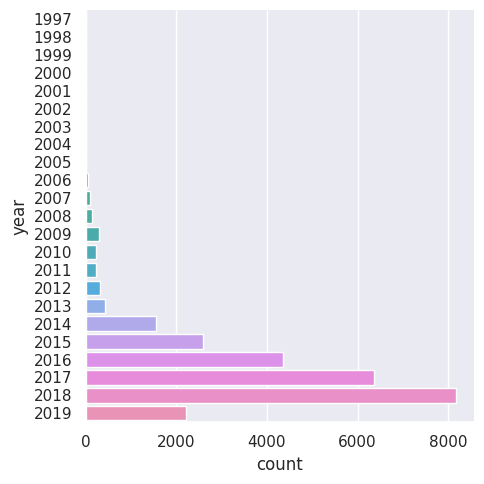

In [13]:
sb.catplot(data=kaggle_steam, y='year', kind='count')

### `english`

It is immediately obvious that `english` is not a very good variable. Over `98%` of the data is `english` and thus it likely has limited effect on clustering.

In [14]:
kaggle_steam['english'].value_counts() / len(kaggle_steam)

1    0.981127
0    0.018873
Name: english, dtype: float64

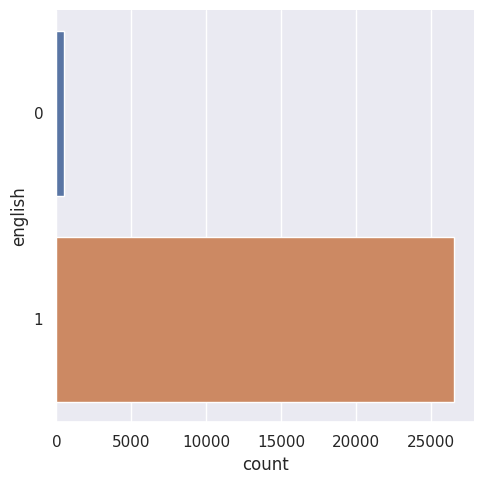

In [15]:
sb.catplot(data=kaggle_steam, y='english', kind='count')

### `owners`

In [16]:
# Take the upper limit as the estimate, then log10
kaggle_steam['est_owners'] = kaggle_steam['owners'].str.split('-').map(lambda x: int(x[1])).map(np.log10)
kaggle_steam['est_owners'].value_counts()

4.30103    18596
4.69897     3059
5.00000     1695
5.30103     1386
5.69897     1272
6.00000      513
6.30103      288
6.69897      193
7.00000       46
7.30103       21
7.69897        3
8.00000        2
8.30103        1
Name: est_owners, dtype: int64

#### Observations

We could take different approach to transforming `owners` to numeric. Either via OrdinalEncoder or another method.

Since the bracket size isn't even, i.e 20000 -> 50000 is 2.5x but 50000 -> 100000 is 2x only, we decided to use the upper limit instead of encoding them as 0..1..2..3 as it is more representative. We also decided to `log10` to reduce the difference between `20,000` and `100,000,000` because a distance that large can throw off the model. Since this is discrete and non-continuous, the violinplot looks funny.

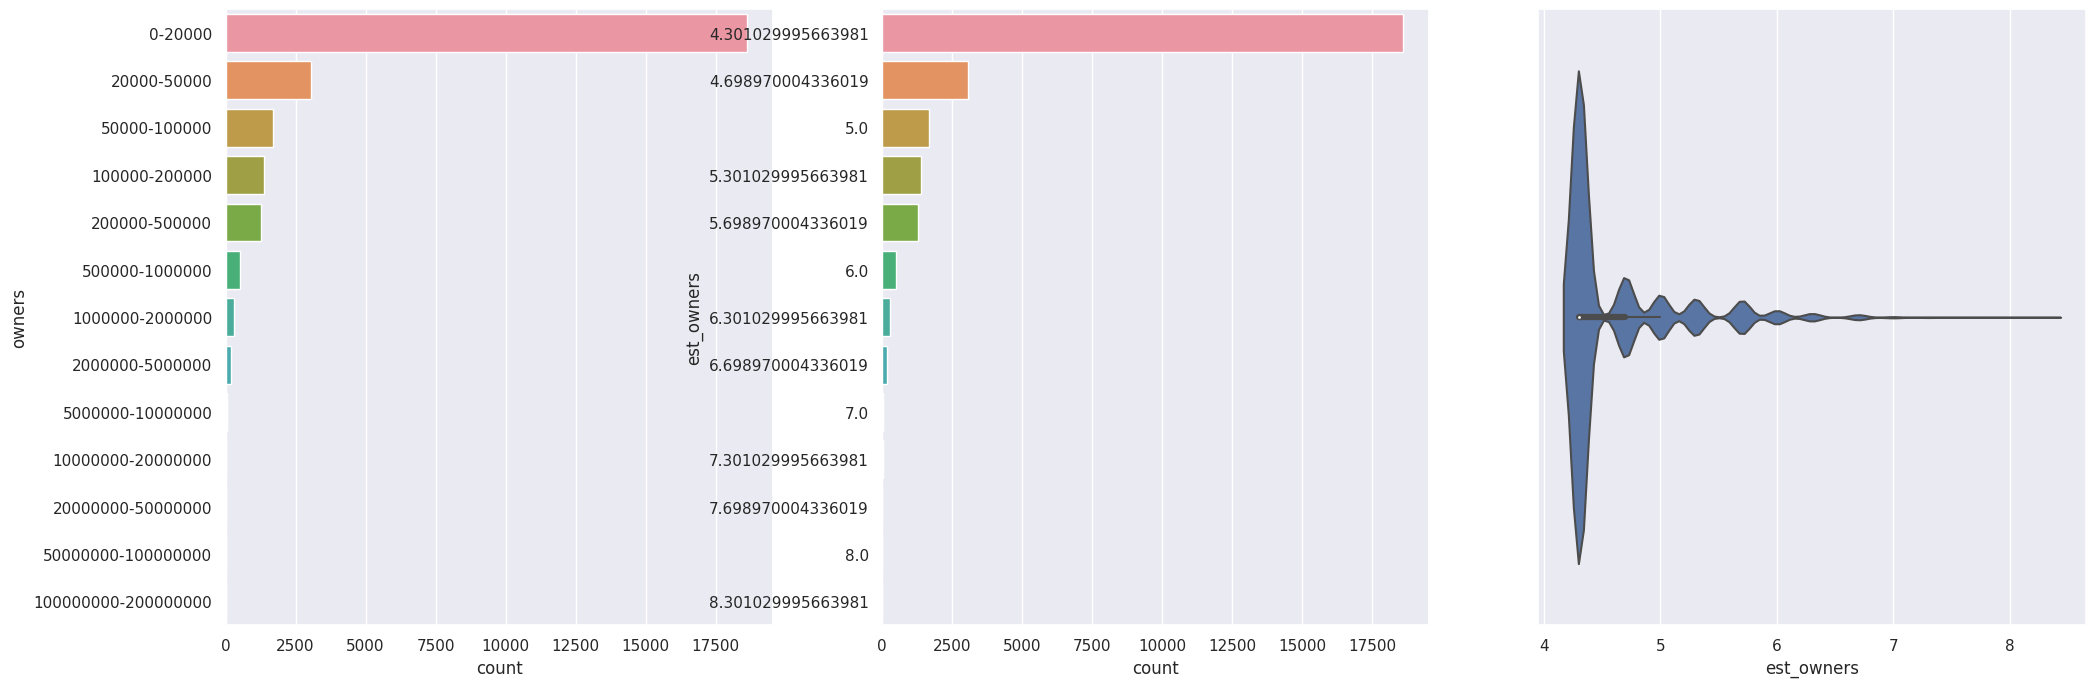

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(24,8))
sb.countplot(data=kaggle_steam, y='owners', order=sorted(kaggle_steam['owners'].unique(), key=lambda x: int(x.split('-')[1])), ax=ax[0])
sb.countplot(data=kaggle_steam, y='est_owners', order=kaggle_steam['est_owners'].unique().sort(), ax=ax[1])
sb.violinplot(data=kaggle_steam, x='est_owners', ax=ax[2])
%matplotlib inline


## Dealing with multi-valued categorical variables

These variables are `platforms`, `categories`, `genres`, `steamspy_tags`, with each value separated by a semicolon (;).

In [18]:
kaggle_steam[['platforms', 'categories', 'genres', 'steamspy_tags']].tail(1)

,platforms,categories,genres,steamspy_tags
27074,windows;mac,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure


In [19]:
def describe_categorical_as_onehot(df: pd.DataFrame, X: pd.Series, keep: "set[str] | 'all'" = None, sep=';'):
  mlb = MultiLabelBinarizer()
  x = mlb.fit_transform(X.str.split(sep)).T
  print(f"Column `{X.name}` has {len(mlb.classes_)} unique labels")
  if keep is not None:
    for i, category in enumerate(mlb.classes_):
      if keep == 'all' or (category in keep):
        df[category] = x[i]
  return mlb.classes_

### `platforms`

In [20]:
describe_categorical_as_onehot(kaggle_steam, kaggle_steam['platforms'], keep={'windows', 'mac', 'linux'})

Column `platforms` has 3 unique labels


array(['linux', 'mac', 'windows'], dtype=object)

In [21]:
kaggle_steam[["platforms", "windows", "mac", "linux"]]

,platforms,windows,mac,linux
0,windows;mac;linux,1,1,1
1,windows;mac;linux,1,1,1
2,windows;mac;linux,1,1,1
3,windows;mac;linux,1,1,1
4,windows;mac;linux,1,1,1
...,...,...,...,...
27070,windows,1,0,0
27071,windows,1,0,0
27072,windows,1,0,0
27073,windows;mac,1,1,0


In [22]:
kaggle_steam[['windows', 'mac', 'linux']].sum() / len(kaggle_steam)

windows    0.999815
mac        0.297913
linux      0.193352
dtype: float64

#### Observations

`99.98%` of all games support windows, it is the most ubiquitous platform, so it is probably not the most useful.

<Axes: ylabel='count'>

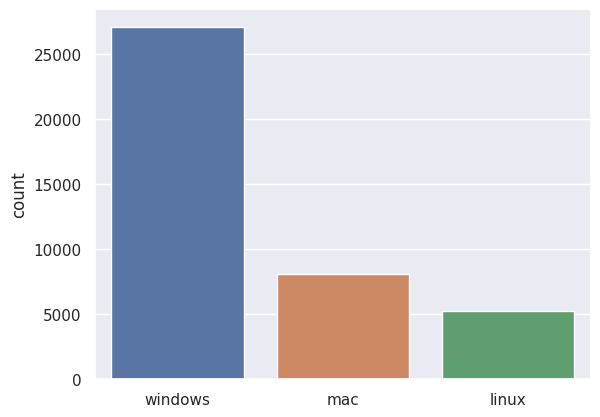

In [23]:
q = kaggle_steam[['windows', 'mac', 'linux']].sum().to_frame(name='count')
sb.barplot(x=q.index, y=q['count'])

### `categories`

We also created a `num_categories` column.

In [24]:
kaggle_steam['num_categories'] = kaggle_steam['categories'].str.split(';').map(len)
kaggle_steam['num_categories']

0        4
1        4
2        2
3        4
4        3
        ..
27070    2
27071    1
27072    7
27073    2
27074    2
Name: num_categories, Length: 27075, dtype: int64

In [25]:
categories_df = pd.DataFrame(np.arange(0, len(kaggle_steam))).drop(labels=0, axis=1)
describe_categorical_as_onehot(categories_df, kaggle_steam['categories'], keep='all')

Column `categories` has 29 unique labels


array(['Captions available', 'Co-op', 'Commentary available',
       'Cross-Platform Multiplayer', 'Full controller support',
       'In-App Purchases', 'Includes Source SDK', 'Includes level editor',
       'Local Co-op', 'Local Multi-Player', 'MMO', 'Mods',
       'Mods (require HL2)', 'Multi-player', 'Online Co-op',
       'Online Multi-Player', 'Partial Controller Support',
       'Shared/Split Screen', 'Single-player', 'Stats',
       'Steam Achievements', 'Steam Cloud', 'Steam Leaderboards',
       'Steam Trading Cards', 'Steam Turn Notifications',
       'Steam Workshop', 'SteamVR Collectibles', 'VR Support',
       'Valve Anti-Cheat enabled'], dtype=object)

In [26]:
pd.concat([kaggle_steam, categories_df], axis=1)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,Stats,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,VR Support,Valve Anti-Cheat enabled
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,1
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,1
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,0,0,0,0,0,0,0,0,0,1
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,1
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,...,0,1,0,0,0,0,0,0,0,0
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,...,0,0,0,0,0,0,0,0,0,0
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,...,0,1,1,0,0,0,0,0,0,0
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,...,0,0,1,0,0,0,0,0,0,0


In [27]:
categories_df

,Captions available,Co-op,Commentary available,Cross-Platform Multiplayer,Full controller support,In-App Purchases,Includes Source SDK,Includes level editor,Local Co-op,Local Multi-Player,...,Stats,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,VR Support,Valve Anti-Cheat enabled
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
27071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,0,1,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
27073,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


It is interesting to note that `Single-player` and `Multi-player` are not mutually exclusive.

In [28]:
categories_df[['Single-player', 'Multi-player']]

,Single-player,Multi-player
0,0,1
1,0,1
2,0,1
3,0,1
4,1,1
...,...,...
27070,1,0
27071,1,0
27072,1,1
27073,1,0


In [29]:
(categories_df.sum() / len(categories_df)).sort_values(ascending=False).head(10)

Single-player                 0.948403
Steam Achievements            0.521884
Steam Trading Cards           0.292447
Steam Cloud                   0.266630
Full controller support       0.210342
Partial Controller Support    0.156380
Multi-player                  0.146777
Steam Leaderboards            0.127018
Online Multi-Player           0.091856
Shared/Split Screen           0.079483
dtype: float64

#### Observations

A lot of the labels appear to be associated with one another, for example `Multi-player` and similar labels such as `Co-op`, `Cross-platform Multiplayer`, etc. `Single-player` is also most likely not going to be useful due to `94.8%` of the dataset supporting solo play, so there is little variance.

In [30]:
# pearson's correlation does not work for categorical data. only continuous data.
# sb.heatmap(categories_df.corr(), vmin=-1, vmax=1, linewidths=1, cmap="RdBu", annot=True, fmt='.2f', ax=plt.subplots(1,1,figsize=(24,20))[1], square=True)

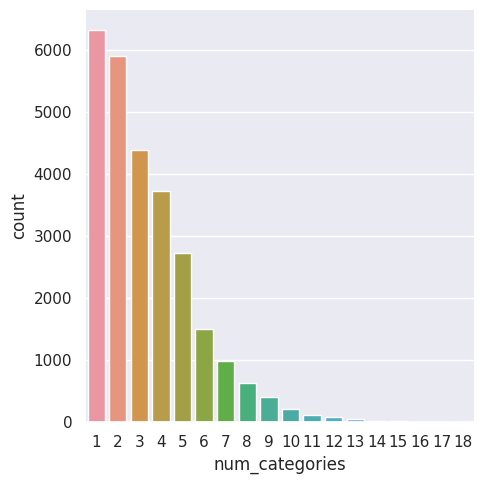

In [31]:
sb.catplot(kaggle_steam, x='num_categories', kind='count')

In [32]:
kaggle_steam['num_categories'].describe()

count    27075.000000
mean         3.313980
std          2.235836
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         18.000000
Name: num_categories, dtype: float64

<Axes: >

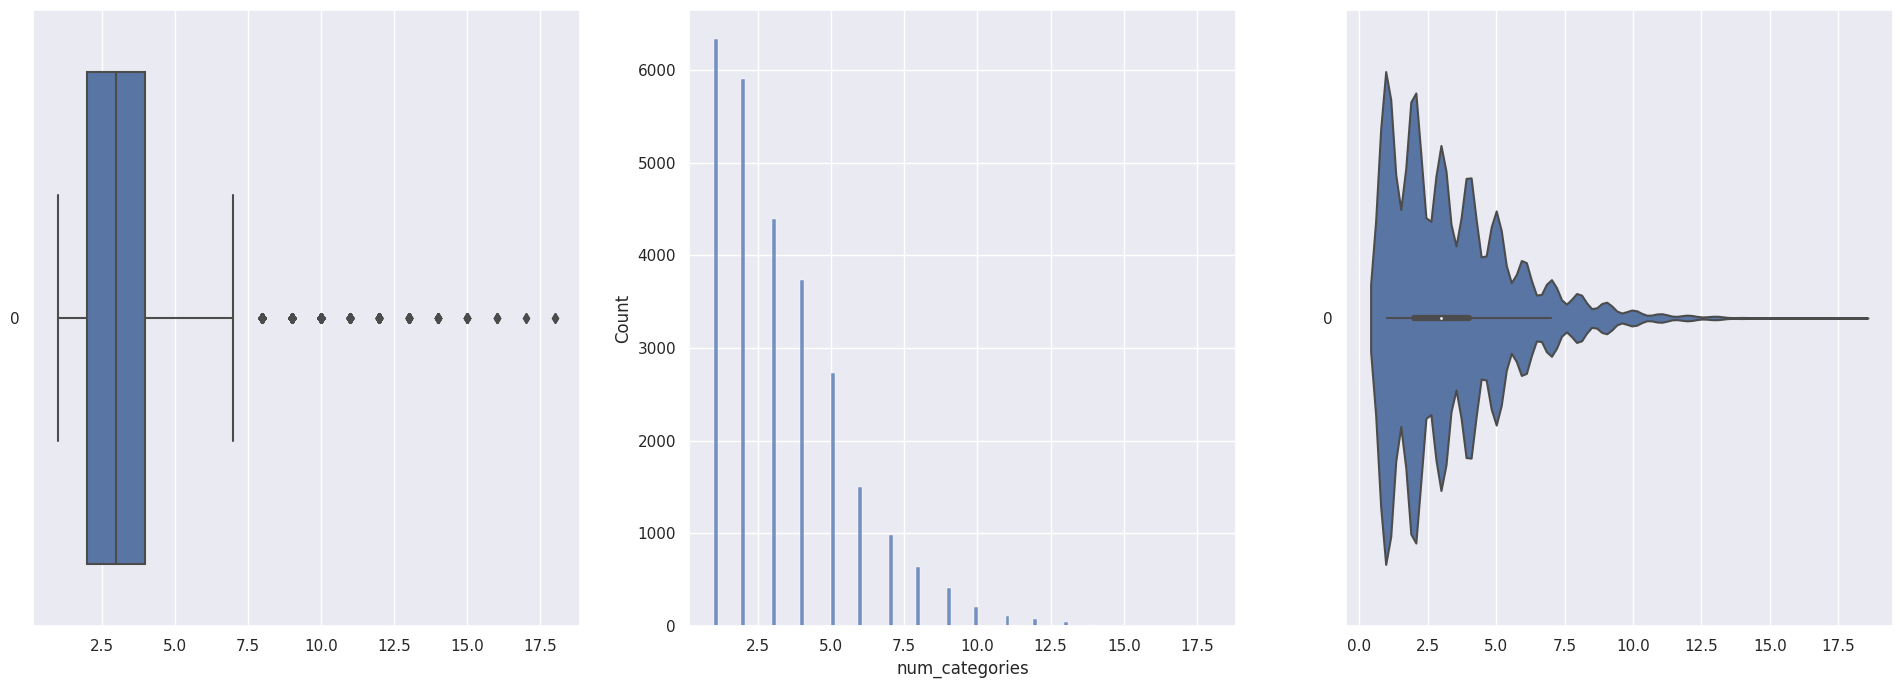

In [33]:
fig, ax = plt.subplots(1,3, figsize=(24, 8))
sb.boxplot(data=kaggle_steam['num_categories'], orient='h', ax=ax[0])

sb.histplot(data=kaggle_steam['num_categories'], ax=ax[1])

sb.violinplot(data=kaggle_steam['num_categories'], orient='h', ax=ax[2])

In [34]:
kaggle_steam[kaggle_steam['num_categories'] > 7]['num_categories'].value_counts()

8     634
9     407
10    204
11    111
12     73
13     46
14     14
15     10
16      5
17      2
18      2
Name: num_categories, dtype: int64

In [35]:
kaggle_steam[kaggle_steam['num_categories'] > 15].sort_values(by='est_owners')

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,average_playtime,median_playtime,owners,price,year,est_owners,linux,mac,windows,num_categories
5574,368180,Polyball,2017-12-01,1,Studio Monolith,Studio Monolith,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Casual;Indie;Racing;Simulation,...,0,0,0-20000,10.99,2017,4.30103,1,1,1,17
7410,420900,Mech Anarchy,2016-03-15,1,Trevor Madge,Trevor Madge,windows,0,Single-player;Multi-player;Online Multi-Player...,Action;Indie;Early Access,...,0,0,0-20000,5.79,2016,4.30103,0,0,1,18
8440,451600,CounterAttack,2019-03-11,1,Relative Games,Relative Games,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Adventure;Indie,...,0,0,0-20000,11.39,2019,4.30103,1,1,1,18
13583,600440,Cyber Complex,2017-08-04,1,PolarityFlow;Adrian Zingg,PolarityFlow,windows;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Casual;Indie;Simulation;Strategy,...,13,13,0-20000,6.99,2017,4.30103,1,0,1,16
2503,273500,Over 9000 Zombies!,2015-02-25,1,Loren Lemcke,Loren Lemcke,windows,0,Single-player;Multi-player;Online Multi-Player...,Action;Indie,...,17,17,100000-200000,1.59,2015,5.30103,0,0,1,16
3651,314970,Age of Conquest IV,2016-04-05,1,Noble Master LLC,Noble Master LLC,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Free to Play;Indie;Strategy,...,93,141,200000-500000,0.00,2016,5.69897,1,1,1,16
4724,346330,BrainBread 2,2016-07-20,1,Reperio Studios,Reperio Studios,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Adventure;Free to Play;Indie;Early Access,...,46,43,1000000-2000000,0.00,2016,6.30103,1,1,1,17
780,41070,Serious Sam 3: BFE,2011-11-22,1,Croteam,Devolver Digital,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Indie,...,378,215,2000000-5000000,29.99,2011,6.69897,1,1,1,16
1764,238460,BattleBlock Theater®,2014-05-15,1,The Behemoth,The Behemoth,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Adventure;Casual;Indie,...,774,289,2000000-5000000,10.99,2014,6.69897,1,1,1,16


<Axes: >

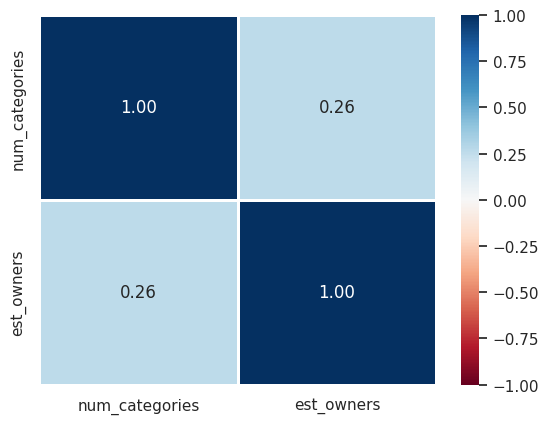

In [36]:
sb.heatmap(kaggle_steam[['num_categories', 'est_owners']].corr(), vmin=-1, vmax=1, linewidths=1, cmap="RdBu", annot=True, fmt='.2f')

### `genres`

We also created a `num_genres` column.

In [37]:
kaggle_steam['num_genres'] = kaggle_steam['genres'].str.split(';').map(len)
kaggle_steam['num_genres']

0        1
1        1
2        1
3        1
4        1
        ..
27070    3
27071    3
27072    3
27073    3
27074    3
Name: num_genres, Length: 27075, dtype: int64

In [38]:
genres_df = pd.DataFrame(np.arange(0, len(kaggle_steam))).drop(labels=0, axis=1)
describe_categorical_as_onehot(genres_df, kaggle_steam['genres'], keep='all')

Column `genres` has 29 unique labels


array(['Accounting', 'Action', 'Adventure', 'Animation & Modeling',
       'Audio Production', 'Casual', 'Design & Illustration',
       'Documentary', 'Early Access', 'Education', 'Free to Play',
       'Game Development', 'Gore', 'Indie', 'Massively Multiplayer',
       'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content',
       'Simulation', 'Software Training', 'Sports', 'Strategy',
       'Tutorial', 'Utilities', 'Video Production', 'Violent',
       'Web Publishing'], dtype=object)

In [39]:
pd.concat([kaggle_steam, genres_df], axis=1)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,Sexual Content,Simulation,Software Training,Sports,Strategy,Tutorial,Utilities,Video Production,Violent,Web Publishing
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,...,0,0,0,0,0,0,0,0,0,0
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,...,0,0,0,0,0,0,0,0,0,0
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,...,0,0,0,0,0,0,0,0,0,0
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,...,0,0,0,0,0,0,0,0,0,0


In [40]:
genres_df

,Accounting,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Documentary,Early Access,Education,...,Sexual Content,Simulation,Software Training,Sports,Strategy,Tutorial,Utilities,Video Production,Violent,Web Publishing
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27073,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
(genres_df.sum() / len(genres_df)).sort_values(ascending=False)

Indie                    0.717304
Action                   0.439631
Casual                   0.377101
Adventure                0.370526
Strategy                 0.193795
Simulation               0.191837
RPG                      0.159224
Early Access             0.109104
Free to Play             0.062936
Sports                   0.048827
Racing                   0.037821
Violent                  0.031136
Massively Multiplayer    0.026704
Gore                     0.019834
Nudity                   0.009825
Sexual Content           0.009049
Utilities                0.005392
Design & Illustration    0.003213
Animation & Modeling     0.002918
Education                0.001884
Video Production         0.001404
Software Training        0.001145
Audio Production         0.001071
Web Publishing           0.001034
Game Development         0.000628
Photo Editing            0.000443
Accounting               0.000222
Tutorial                 0.000037
Documentary              0.000037
dtype: float64

#### Observations

We see many labels for software instead of games in general like `Accounting`, `Animation & Modelling`, `Audio Production`, `Design & Illustration` etc. It might be possible for the clustering algorithm to identify software applications as a cluster. 

In [42]:
# pearson's correlation does not work for categorical data. only continuous data.
# sb.heatmap(genres_df.corr(), vmin=-1, vmax=1, linewidths=1, cmap="RdBu", annot=True, fmt='.2f', ax=plt.subplots(1,1,figsize=(24,20))[1], square=True)

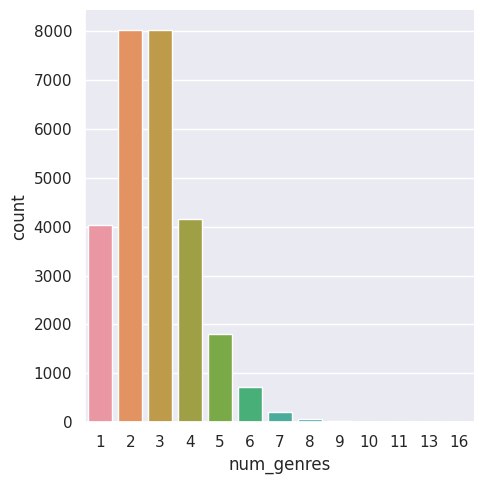

In [43]:
sb.catplot(kaggle_steam, x='num_genres', kind='count')

In [44]:
kaggle_steam['num_genres'].describe()

count    27075.000000
mean         2.824081
std          1.333244
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: num_genres, dtype: float64

<Axes: >

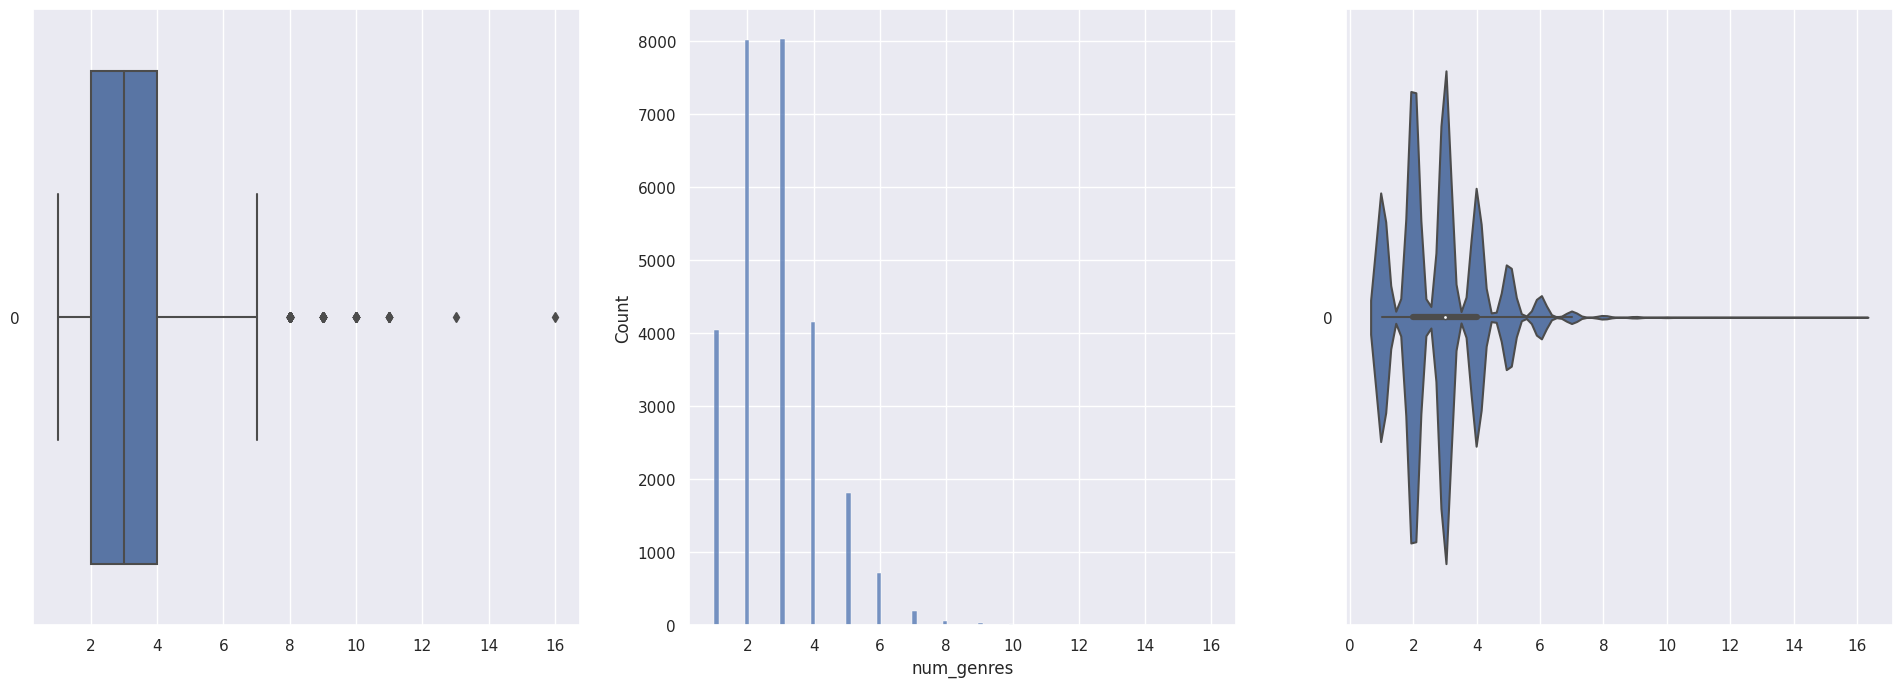

In [45]:
fig, ax = plt.subplots(1,3, figsize=(24, 8))
sb.boxplot(data=kaggle_steam['num_genres'], orient='h', ax=ax[0])

sb.histplot(data=kaggle_steam['num_genres'], ax=ax[1])

sb.violinplot(data=kaggle_steam['num_genres'], orient='h', ax=ax[2])

In [46]:
kaggle_steam[kaggle_steam['num_genres'] > 7]['num_genres'].value_counts()

8     60
9     26
10    12
11     7
13     1
16     1
Name: num_genres, dtype: int64

#### Observations 2

It seems that genres > 10 are filled with games that are somewhat unpopular. Perhaps this is a marketing scheme to make the game show up in more searches and hence increase the likelihood of them being purchased. However, based on our investigation, this proves to be untrue (corr=-0.07). There is also no correlation between `num_categories` and `num_genres`.

In [47]:
kaggle_steam[kaggle_steam['num_genres'] > 10].sort_values(by='est_owners')

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,median_playtime,owners,price,year,est_owners,linux,mac,windows,num_categories,num_genres
16768,697630,WARMA,2018-06-19,1,WARMA Corporation,WARMA Corporation,windows,0,Online Multi-Player;MMO,Nudity;Violent;Gore;Action;Adventure;Indie;Mas...,...,0,0-20000,9.29,2018,4.30103,0,0,1,2,11
24494,933920,GIRLS VR UNCENSORED!!!,2018-09-28,1,Eroticon VR,Eroticon VR,windows,0,Single-player,Action;Adventure;Casual;Free to Play;Indie;Mas...,...,0,0-20000,9.29,2018,4.30103,0,0,1,1,11
24515,934710,英语杀,2018-11-04,0,边玩边学网络科技有限公司,边玩边学网络科技有限公司,windows,0,Single-player,Casual;Free to Play;Indie;RPG;Strategy;Account...,...,0,0-20000,0.00,2018,4.30103,0,0,1,1,16
24524,934990,Cute Girls VR,2018-09-22,1,Tomimar,Tomimar,windows,0,Single-player,Action;Adventure;Casual;Free to Play;Indie;Mas...,...,0,0-20000,6.19,2018,4.30103,0,0,1,1,11
25010,953610,HOT GIRLS VR,2018-10-26,1,tomimar,tomimar,windows,0,Single-player,Action;Adventure;Casual;Free to Play;Indie;Mas...,...,0,0-20000,9.29,2018,4.30103,0,0,1,1,11
25118,958300,Cute Girls 可爱的女孩,2018-10-21,1,Dance studio mix,Dance studio mix,windows,0,Single-player,Action;Adventure;Casual;Free to Play;Indie;Mas...,...,0,0-20000,2.89,2018,4.30103,0,0,1,1,11
25951,994320,Night City 2177,2019-02-23,1,Alongini,Alongini,windows,0,Single-player,Action;Adventure;Casual;Free to Play;Indie;Mas...,...,0,0-20000,2.89,2019,4.30103,0,0,1,1,11
26957,1050150,Sexy Miss,2019-04-20,1,Sexy Miss Studio,Sexy Miss Studio,windows,0,Single-player,Action;Adventure;Casual;Free to Play;Indie;Mas...,...,0,0-20000,13.99,2019,4.30103,0,0,1,1,11
20466,803010,Supermedium - Virtual Reality Browser,2018-03-06,1,Supermedium,Supermedium,windows,0,Single-player,Casual;Free to Play;Indie;Accounting;Animation...,...,0,20000-50000,0.00,2018,4.69897,0,0,1,1,13


<Axes: >

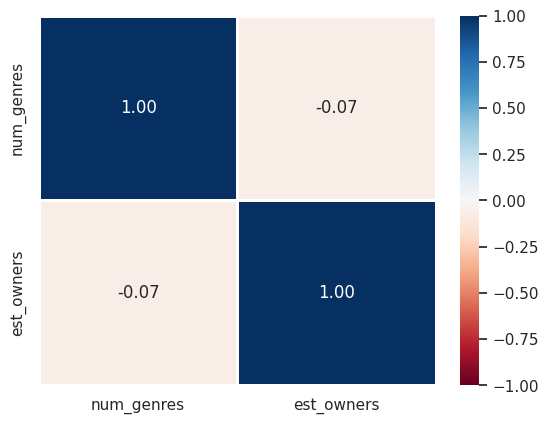

In [48]:
sb.heatmap(kaggle_steam[['num_genres', 'est_owners']].corr(), vmin=-1, vmax=1, linewidths=1, cmap="RdBu", annot=True, fmt='.2f')

<Axes: >

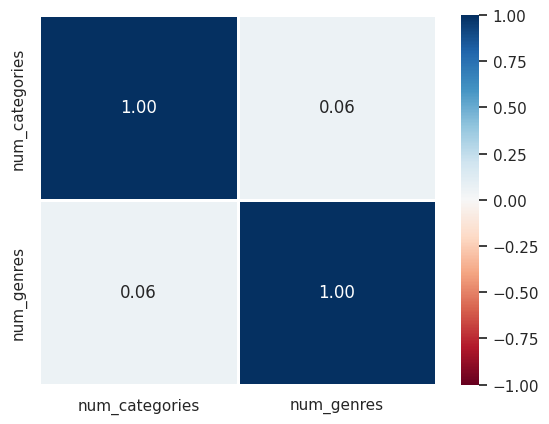

In [49]:
sb.heatmap(kaggle_steam[['num_categories', 'num_genres']].corr(), vmin=-1, vmax=1, linewidths=1, cmap="RdBu", annot=True, fmt='.2f')

### `steamspy_tags`

In [50]:
kaggle_steam['num_steamspy_tags'] = kaggle_steam['steamspy_tags'].str.split(';').map(len)
kaggle_steam['num_steamspy_tags']

0        3
1        3
2        3
3        3
4        3
        ..
27070    3
27071    3
27072    3
27073    3
27074    3
Name: num_steamspy_tags, Length: 27075, dtype: int64

In [51]:
import warnings
warnings.filterwarnings('ignore')
tags_df = pd.DataFrame(np.arange(0, len(kaggle_steam))).drop(labels=0, axis=1)
r = describe_categorical_as_onehot(tags_df, kaggle_steam['steamspy_tags'], keep='all') # this generates a lot of warnings
warnings.filterwarnings('default')
tags_df = tags_df.copy(deep=True)
r

Column `steamspy_tags` has 339 unique labels


array(['1980s', "1990's", '2.5D', '2D', '2D Fighter', '360 Video', '3D',
       '3D Platformer', '3D Vision', '4 Player Local', '4X', '6DOF',
       'Abstract', 'Action', 'Action RPG', 'Action-Adventure',
       'Adventure', 'Agriculture', 'Aliens', 'Alternate History',
       'America', 'Animation & Modeling', 'Anime', 'Arcade',
       'Arena Shooter', 'Assassin', 'Atmospheric', 'Audio Production',
       'BMX', 'Base-Building', 'Baseball', 'Basketball', 'Batman',
       'Battle Royale', "Beat 'em up", 'Beautiful', 'Benchmark', 'Bikes',
       'Blood', 'Board Game', 'Bowling', 'Building', 'Bullet Hell',
       'Bullet Time', 'CRPG', 'Capitalism', 'Card Game', 'Cartoon',
       'Cartoony', 'Casual', 'Cats', 'Character Action Game',
       'Character Customization', 'Chess', 'Choices Matter',
       'Choose Your Own Adventure', 'Cinematic', 'City Builder',
       'Class-Based', 'Classic', 'Clicker', 'Co-op', 'Cold War',
       'Colorful', 'Comedy', 'Comic Book', 'Competitive', 'Controll

In [52]:
(tags_df.sum() / len(tags_df)).sort_values(ascending=False)

Indie                             0.599520
Action                            0.381237
Casual                            0.303047
Adventure                         0.286981
Strategy                          0.154127
                                    ...   
Investigation                     0.000037
Cinematic                         0.000037
Inventory Management              0.000037
Intentionally Awkward Controls    0.000037
Logic                             0.000037
Length: 339, dtype: float64

#### Observation 1

Most tags are very seldomly used/too specific. 75% of tags are only used by just 55 games. While specific tags can help carve out clusters, if they are only represented by a few games, it could mean that the label itself is not very widely-known/accepted as of yet. It could also just be a synonym for another tag. Hence we should be careful about which labels we decide to include. Since we want to carve out general clusters rather than specific clusters, we can most likely set a threshold to filter less popular tags.

Furthermore, some of these tags appear to be the same labels as genres.

In [53]:
tags_df.sum().describe()

count      339.000000
mean       230.094395
std       1258.224753
min          1.000000
25%          4.000000
50%         14.000000
75%         55.000000
max      16232.000000
dtype: float64

# Summary

- Pearson's correlation coefficient cannot be used for categorical data. (association, chi-squared?)
- PCA cannot be used for categorical data. (MCA, MFA)
- K-means cannot be used for categorical data. (k-modes, k-prototype)

real numeric:
- num_categories
- num_genres
- num_steamspy_tags
- year

pseudo numeric:
- est_owners

Perhaps could try: TargetEncoder
- for platforms
- for categories
- for genre

# KMeans, KModes & KPrototypes

KMeans only works with numerical data. Since our dataset has a lot of categorical variables that we can exploit, we decided to try a variation of KMeans known as KPrototypes instead that offers support for both numerical and categorical data. 

KPrototypes is not available in `scikit-learn` but is available via the `kmodes` library.

In [54]:
kaggle_steam['Single-player'] = categories_df['Single-player']
kaggle_steam['Multi-player'] = categories_df['Multi-player']

In [55]:
categorical = ['english', 'windows', 'mac', 'linux', 'Single-player', 'Multi-player'] # + list(genres_df.columns)
numerical = ['required_age', 'achievements', 'positive_ratings', 'negative_ratings',
             'average_playtime', 'median_playtime', 'price',
             'year', 'est_owners', 'num_categories', 'num_genres', 'num_steamspy_tags']
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(kaggle_steam.loc[:, numerical]), columns=numerical)
X = pd.concat([kaggle_steam.loc[:, categorical], X], axis=1)
X

,english,windows,mac,linux,Single-player,Multi-player,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,year,est_owners,num_categories,num_genres,num_steamspy_tags
0,1,1,1,1,0,1,-0.147507,-0.128306,6.505741,0.730006,9.557829,0.072624,0.141186,-7.648808,5.213985,0.306835,-1.368178,0.311447
1,1,1,1,1,0,1,-0.147507,-0.128306,0.122045,0.098480,0.069619,-0.035710,-0.265175,-8.112426,4.636120,0.306835,-1.368178,0.311447
2,1,1,1,1,0,1,-0.147507,-0.128306,0.127206,0.043636,0.020358,-0.047606,-0.265175,-6.257955,4.636120,-0.587702,-1.368178,0.311447
3,1,1,1,1,0,1,-0.147507,-0.128306,0.014348,0.013063,0.059220,0.016120,-0.265175,-7.185190,4.636120,0.306835,-1.368178,0.311447
4,1,1,1,1,1,1,-0.147507,-0.128306,0.223792,0.017964,0.259548,0.114258,-0.265175,-8.112426,4.636120,-0.140433,-1.368178,0.311447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1,1,0,0,1,0,-0.147507,-0.108457,-0.052535,-0.049249,-0.081995,-0.062050,-0.506452,1.159926,-0.544894,-0.587702,0.131950,0.311447
27071,1,1,0,0,1,0,-0.147507,-0.128306,-0.052272,-0.049016,-0.081995,-0.062050,-0.557247,1.159926,-0.544894,-1.034970,0.131950,0.311447
27072,1,1,0,0,1,1,-0.147507,-0.060252,-0.052693,-0.049016,-0.081995,-0.062050,-0.265175,1.159926,-0.544894,1.648640,0.131950,0.311447
27073,1,1,1,0,1,0,-0.147507,-0.128306,-0.052588,-0.049249,-0.081995,-0.062050,-0.112790,1.159926,-0.544894,-0.587702,0.131950,0.311447


In [70]:
catalog.save('train', X)
catalog.save('model@scaler', scaler)

[04/04/23 13:17:12] INFO     Saving data to 'train' (CSVDataSet)...                             ]8;id=925646;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=99069;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#382\382]8;;\

                    INFO     Saving data to 'model@scaler' (PickleDataSet)...                   ]8;id=531013;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=468603;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [56]:
def cluster(n=1):
  model = KPrototypes(n_clusters = n, n_jobs = -1, random_state = 0)
  log.info("Performing clustering for n=%d", n)
  y = model.fit_predict(X=X, y=kaggle_steam.loc[:, 'appid'], categorical=list(range(0, len(categorical))))
  log.info("cost[%d]=%.2f", n, model.cost_)
  return model, y


## Optimal number of clusters

From our result, we see that `n=8` is an optimal number of clusters using the elbow method.

However, the drawback of clustering algorithms is that they are very slow on dataset with high number of dimensions. 

In [60]:
# Previous cell crashed and is too expensive to rerun so we can only extract the values from the output
c_cost = [
    334494.00, 300944.65, 274149.66, 238115.37, 213316.95,
    200341.78, 175751.44, 144311.02, 136494.52, 130838.47,
    119458.53, 112903.93, 104922.15, 106635.56, 101516.58,
     90770.85,  90480.87,  94349.20,  89394.33,  82526.99,
     80919.22,  78468.22,  76235.12,  75527.12,  73756.58,
     72579.18,  77144.13
]

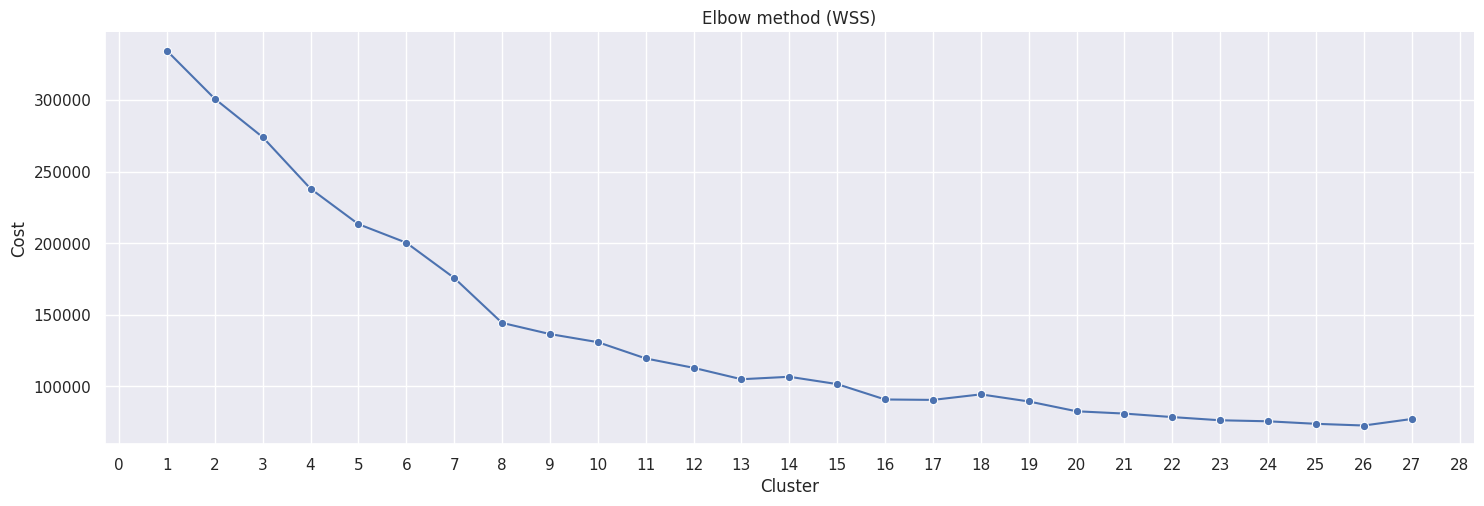

In [61]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':list(range(1, len(c_cost)+1)), 'Cost':c_cost})
ax = sb.relplot(data=df_cost, x='Cluster', y='Cost', marker='o', kind='line', aspect=3).set(title='Elbow method (WSS)')
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

In [71]:
model = None
y = None
if catalog.exists('model@kprototypes@8'):
    model = catalog.load('model@kprototypes@8')
    y = catalog.load('labels@kprototypes@8')
else:
    model, y = cluster(n=8)
    catalog.save('model@kprototypes@8', model)
    catalog.save('labels@kprototypes@8', pd.Series(y, name='cluster'))
    
kaggle_steam['cluster'] = y


[04/04/23 13:17:50] INFO     Loading data from 'model@kprototypes@8' (PickleDataSet)...         ]8;id=477496;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=89352;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'labels@kprototypes@8' (CSVDataSet)...           ]8;id=567583;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=497928;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

## Interpretation

From the results of our 8 clusters, as we predicted, the `english` and `windows` column had 0 effect on our clusters as all of the clusters centroid were at `1.0`.

In [73]:
scaler = catalog.load('model@scaler')

[04/04/23 13:20:54] INFO     Loading data from 'model@scaler' (PickleDataSet)...                ]8;id=845257;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=970972;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [74]:
oc = pd.DataFrame(model.cluster_centroids_, columns=numerical+categorical)
c = pd.DataFrame(scaler.inverse_transform(oc.loc[:, numerical]), columns=numerical)
c['est_owners'] = significant_digits((10 ** c['est_owners']), significance=3).map(int)
c = pd.concat([c, oc.loc[:,categorical]], axis=1)
c['ratings_ratio'] = c['positive_ratings'] / c['negative_ratings']
c.round(2)

,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,year,est_owners,num_categories,num_genres,num_steamspy_tags,english,windows,mac,linux,Single-player,Multi-player,ratings_ratio
0,0.01,33.36,333.67,92.48,106.99,116.93,10.39,2016.68,34400,6.14,2.93,3.00,1.0,1.0,0.0,0.0,1.0,0.0,3.61
1,16.58,31.78,8504.74,1803.82,572.10,381.60,12.36,2015.32,178000,4.02,2.51,2.97,1.0,1.0,0.0,0.0,1.0,0.0,4.71
2,0.01,25.05,4196.44,772.88,555.09,478.40,6.90,2013.25,333000,3.82,2.39,3.00,1.0,1.0,0.0,0.0,1.0,0.0,5.43
3,0.01,14.27,14.20,8.58,12.91,13.40,4.40,2016.79,22800,2.19,1.52,1.79,1.0,1.0,0.0,0.0,1.0,0.0,1.65
4,-0.00,17.25,1016.25,284.25,80140.13,112859.50,8.23,2016.00,126000,3.50,3.50,3.00,1.0,1.0,1.0,0.0,1.0,0.0,3.58
5,0.00,68.00,1334698.33,343822.67,23125.33,6579.00,9.00,2014.00,126000000,6.00,2.67,3.00,1.0,1.0,1.0,1.0,0.0,1.0,3.88
6,0.00,15.92,55.07,17.15,19.28,20.73,4.24,2017.24,23900,2.26,3.14,3.00,1.0,1.0,0.0,0.0,1.0,0.0,3.21
7,0.00,4741.06,101.18,31.54,382.87,381.28,4.41,2017.50,26800,2.42,3.40,2.86,1.0,1.0,0.0,0.0,1.0,0.0,3.21


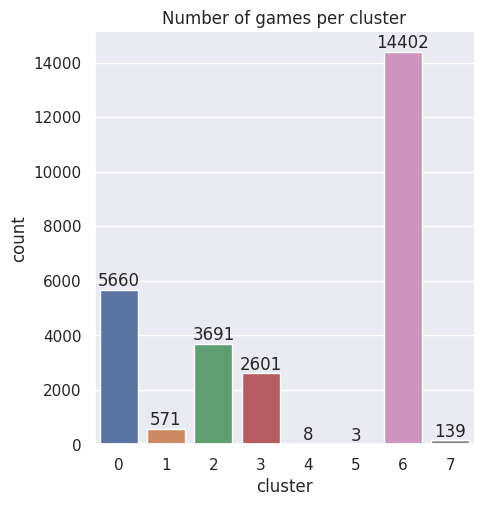

In [ ]:
ax = sb.catplot(data=kaggle_steam, x='cluster', kind='count').set(title="Number of games per cluster")

for label in ax.fig.gca().containers:
    ax.fig.gca().bar_label(label)

# Analysis of cluster groups

Below we display the cluster centroids (0-7) together with the overall statistics of the entire dataset for ease of comparison.

In [82]:
selected_columns = ['year', 'achievements', 'required_age', 'achievements', 'price', 'est_owners', # general information
                    'num_categories', 'num_genres', 'num_steamspy_tags', # imputed information
                    'positive_ratings', 'negative_ratings', 'ratings_ratio', # dependent information
                    'average_playtime', 'median_playtime', # dependent information
                    'mac', 'linux', 'Single-player', 'Multi-player'] # categorical, with english and windows removed as they are useless 

In [83]:
t = kaggle_steam.copy()
t['est_owners'] = 10 ** t['est_owners']
t['ratings_ratio'] = t['positive_ratings'] / t['negative_ratings']
pd.concat([t[selected_columns].describe(), c[selected_columns]]).round(1)

,year,achievements,required_age,achievements,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,ratings_ratio,average_playtime,median_playtime,mac,linux,Single-player,Multi-player
count,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0,27075.0
mean,2016.5,45.2,0.4,45.2,6.1,188054.3,3.3,2.8,2.9,1000.6,211.0,inf,149.8,146.1,0.3,0.2,0.9,0.1
std,2.2,352.7,2.4,352.7,7.9,1786800.7,2.2,1.3,0.4,18988.7,4284.9,NaN,1827.0,2353.9,0.5,0.4,0.2,0.4
min,1997.0,0.0,0.0,0.0,0.0,20000.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2016.0,0.0,0.0,0.0,1.7,20000.0,2.0,2.0,3.0,6.0,2.0,1.4,0.0,0.0,0.0,0.0,1.0,0.0
50%,2017.0,7.0,0.0,7.0,4.0,20000.0,3.0,3.0,3.0,24.0,9.0,3.2,0.0,0.0,0.0,0.0,1.0,0.0
75%,2018.0,23.0,0.0,23.0,7.2,50000.0,4.0,4.0,3.0,126.0,42.0,8.4,0.0,0.0,1.0,0.0,1.0,0.0
max,2019.0,9821.0,18.0,9821.0,422.0,200000000.0,18.0,16.0,3.0,2644404.0,487076.0,inf,190625.0,190625.0,1.0,1.0,1.0,1.0
0,2016.7,33.4,0.0,33.4,10.4,34400.0,6.1,2.9,3.0,333.7,92.5,3.6,107.0,116.9,0.0,0.0,1.0,0.0
1,2015.3,31.8,16.6,31.8,12.4,178000.0,4.0,2.5,3.0,8504.7,1803.8,4.7,572.1,381.6,0.0,0.0,1.0,0.0


## Cluster 0
Highest number of categories


### Remarks
Creative/Strategy games that support many different modes of playing, e.g. workshop level editor, mods, etc.

In [ ]:
c.loc[0, selected_columns].round(2).to_frame().T

,year,achievements,required_age,achievements,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,ratings_ratio,average_playtime,median_playtime,mac,linux,Single-player,Multi-player
0,2016.68,33.36,0.01,33.36,10.39,34400.0,6.14,2.93,3.0,333.67,92.48,3.61,106.99,116.93,0.0,0.0,1.0,0.0


## Cluster 1

The standout feature of this group seems to be `required_age`, with a minimum age of about 16 to 17 years old. (required age)  
Generally, these games receive generally very good reviews, with around 1 negative review for every 4.7 good reviews. (ratings)  
There seems average playtime
### Genre analysis
- We notice that all the software/productivity tools are not present in this cluster (because they don't usually have minimum age)

In [ ]:
c.loc[1, selected_columns].round(2).to_frame().T

,year,achievements,required_age,achievements,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,ratings_ratio,average_playtime,median_playtime,mac,linux,Single-player,Multi-player
1,2015.32,31.78,16.58,31.78,12.36,178000.0,4.02,2.51,2.97,8504.74,1803.82,4.71,572.1,381.6,0.0,0.0,1.0,0.0


## Cluster 2
Games that were released quite early < 25 percentile and average playtime. 

### Remarks

We see that all clusters with the exception of clusters 1, 2 and 3 do not have any games before 2010. However, cluster 2 peaks before 2006 and growth slows down past 2006, while 1 and 3 are flatlines before 2005, thus supporting our analysis.

In [ ]:
c.loc[2, selected_columns].round(2).to_frame().T

,year,achievements,required_age,achievements,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,ratings_ratio,average_playtime,median_playtime,mac,linux,Single-player,Multi-player
2,2013.25,25.05,0.01,25.05,6.9,333000.0,3.82,2.39,3.0,4196.44,772.88,5.43,555.09,478.4,0.0,0.0,1.0,0.0


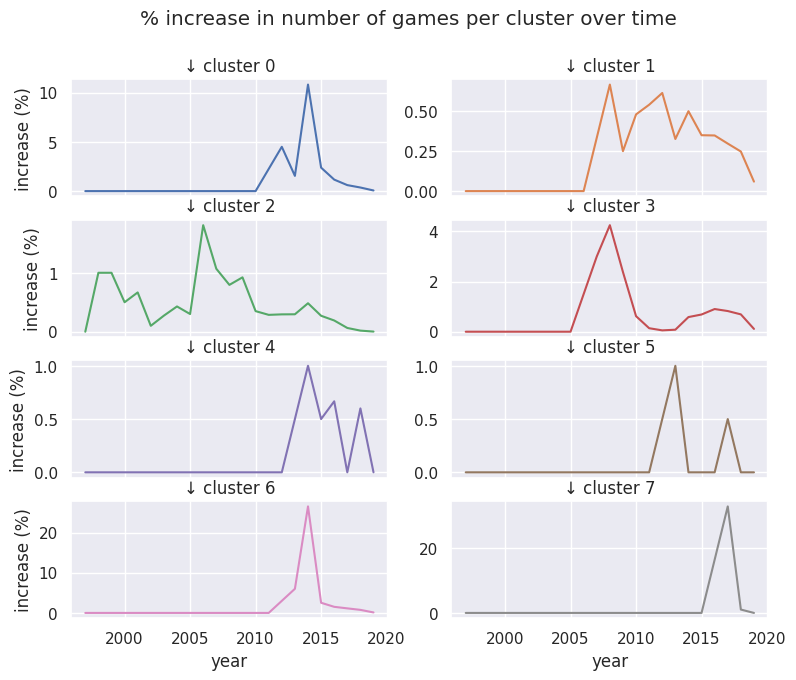

In [ ]:
cumyearschng = (kaggle_steam
                .groupby(by=['cluster', 'year'])
                .agg('count')
                .iloc[:, 0]
                .rename('count')
                .reset_index()
                .pivot(index='year', columns='cluster', values='count')
                .fillna(0) # for years which have no game data, set as 0
                .cumsum()
                .pct_change()
                .fillna(0) # for games count=0, change is NaN as it will be 0/0, fill these with 0 instead
                .unstack()
                .sort_index()
                .rename('increase (%)')
                .reset_index())

cumyearschng['cluster'] = cumyearschng['cluster'].map(str)
fig = plt.figure(figsize=(9,7))
fig.suptitle("% increase in number of games per cluster over time")
(Plot(cumyearschng, "year", "increase (%)", color="cluster")
 .add(so.Line(), legend=False)
 .facet("cluster", wrap=2)
 .share(y=False)
 .label(col="↓ cluster")
 .on(fig)
 .show())

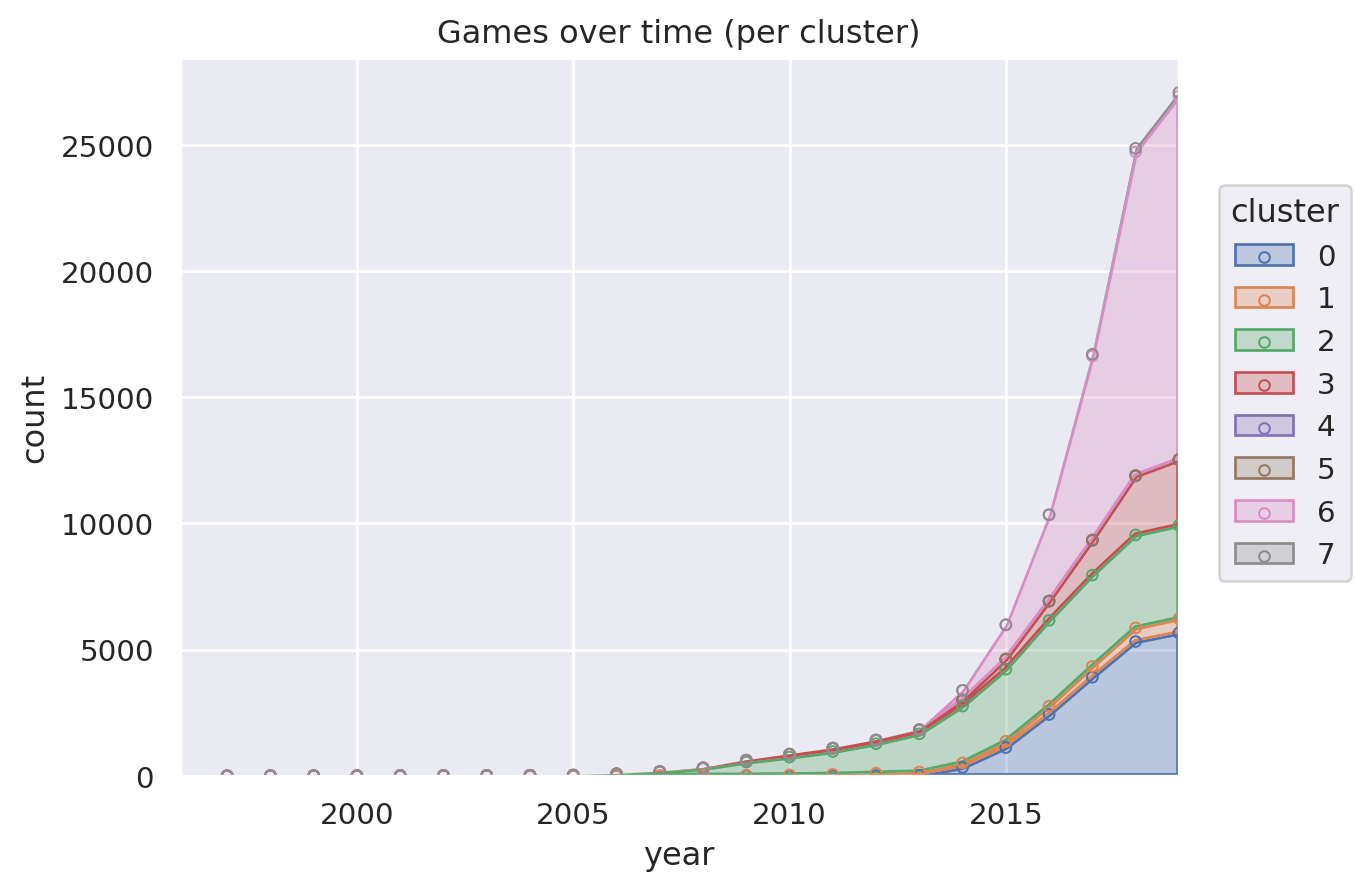

In [ ]:
cumyears = (kaggle_steam
            .groupby(by=['cluster', 'year'])
            .agg('count')
            .iloc[:, 0]
            .rename('count')
            .reset_index()
            .pivot(index='year', columns='cluster', values='count')
            .fillna(0) # for years which have no game data, set as 0
            .cumsum()
            .unstack()
            .rename('count')
            .reset_index())

cumyears['cluster'] = cumyears['cluster'].map(str)

(Plot(cumyears, "year", "count", color="cluster")
    .add(so.Area(alpha=.3), so.Stack())
    .add(so.Dot(pointsize=4, fill=None), so.Stack())
    .limit(x=(None, 2019))
    .label(title='Games over time (per cluster)'))

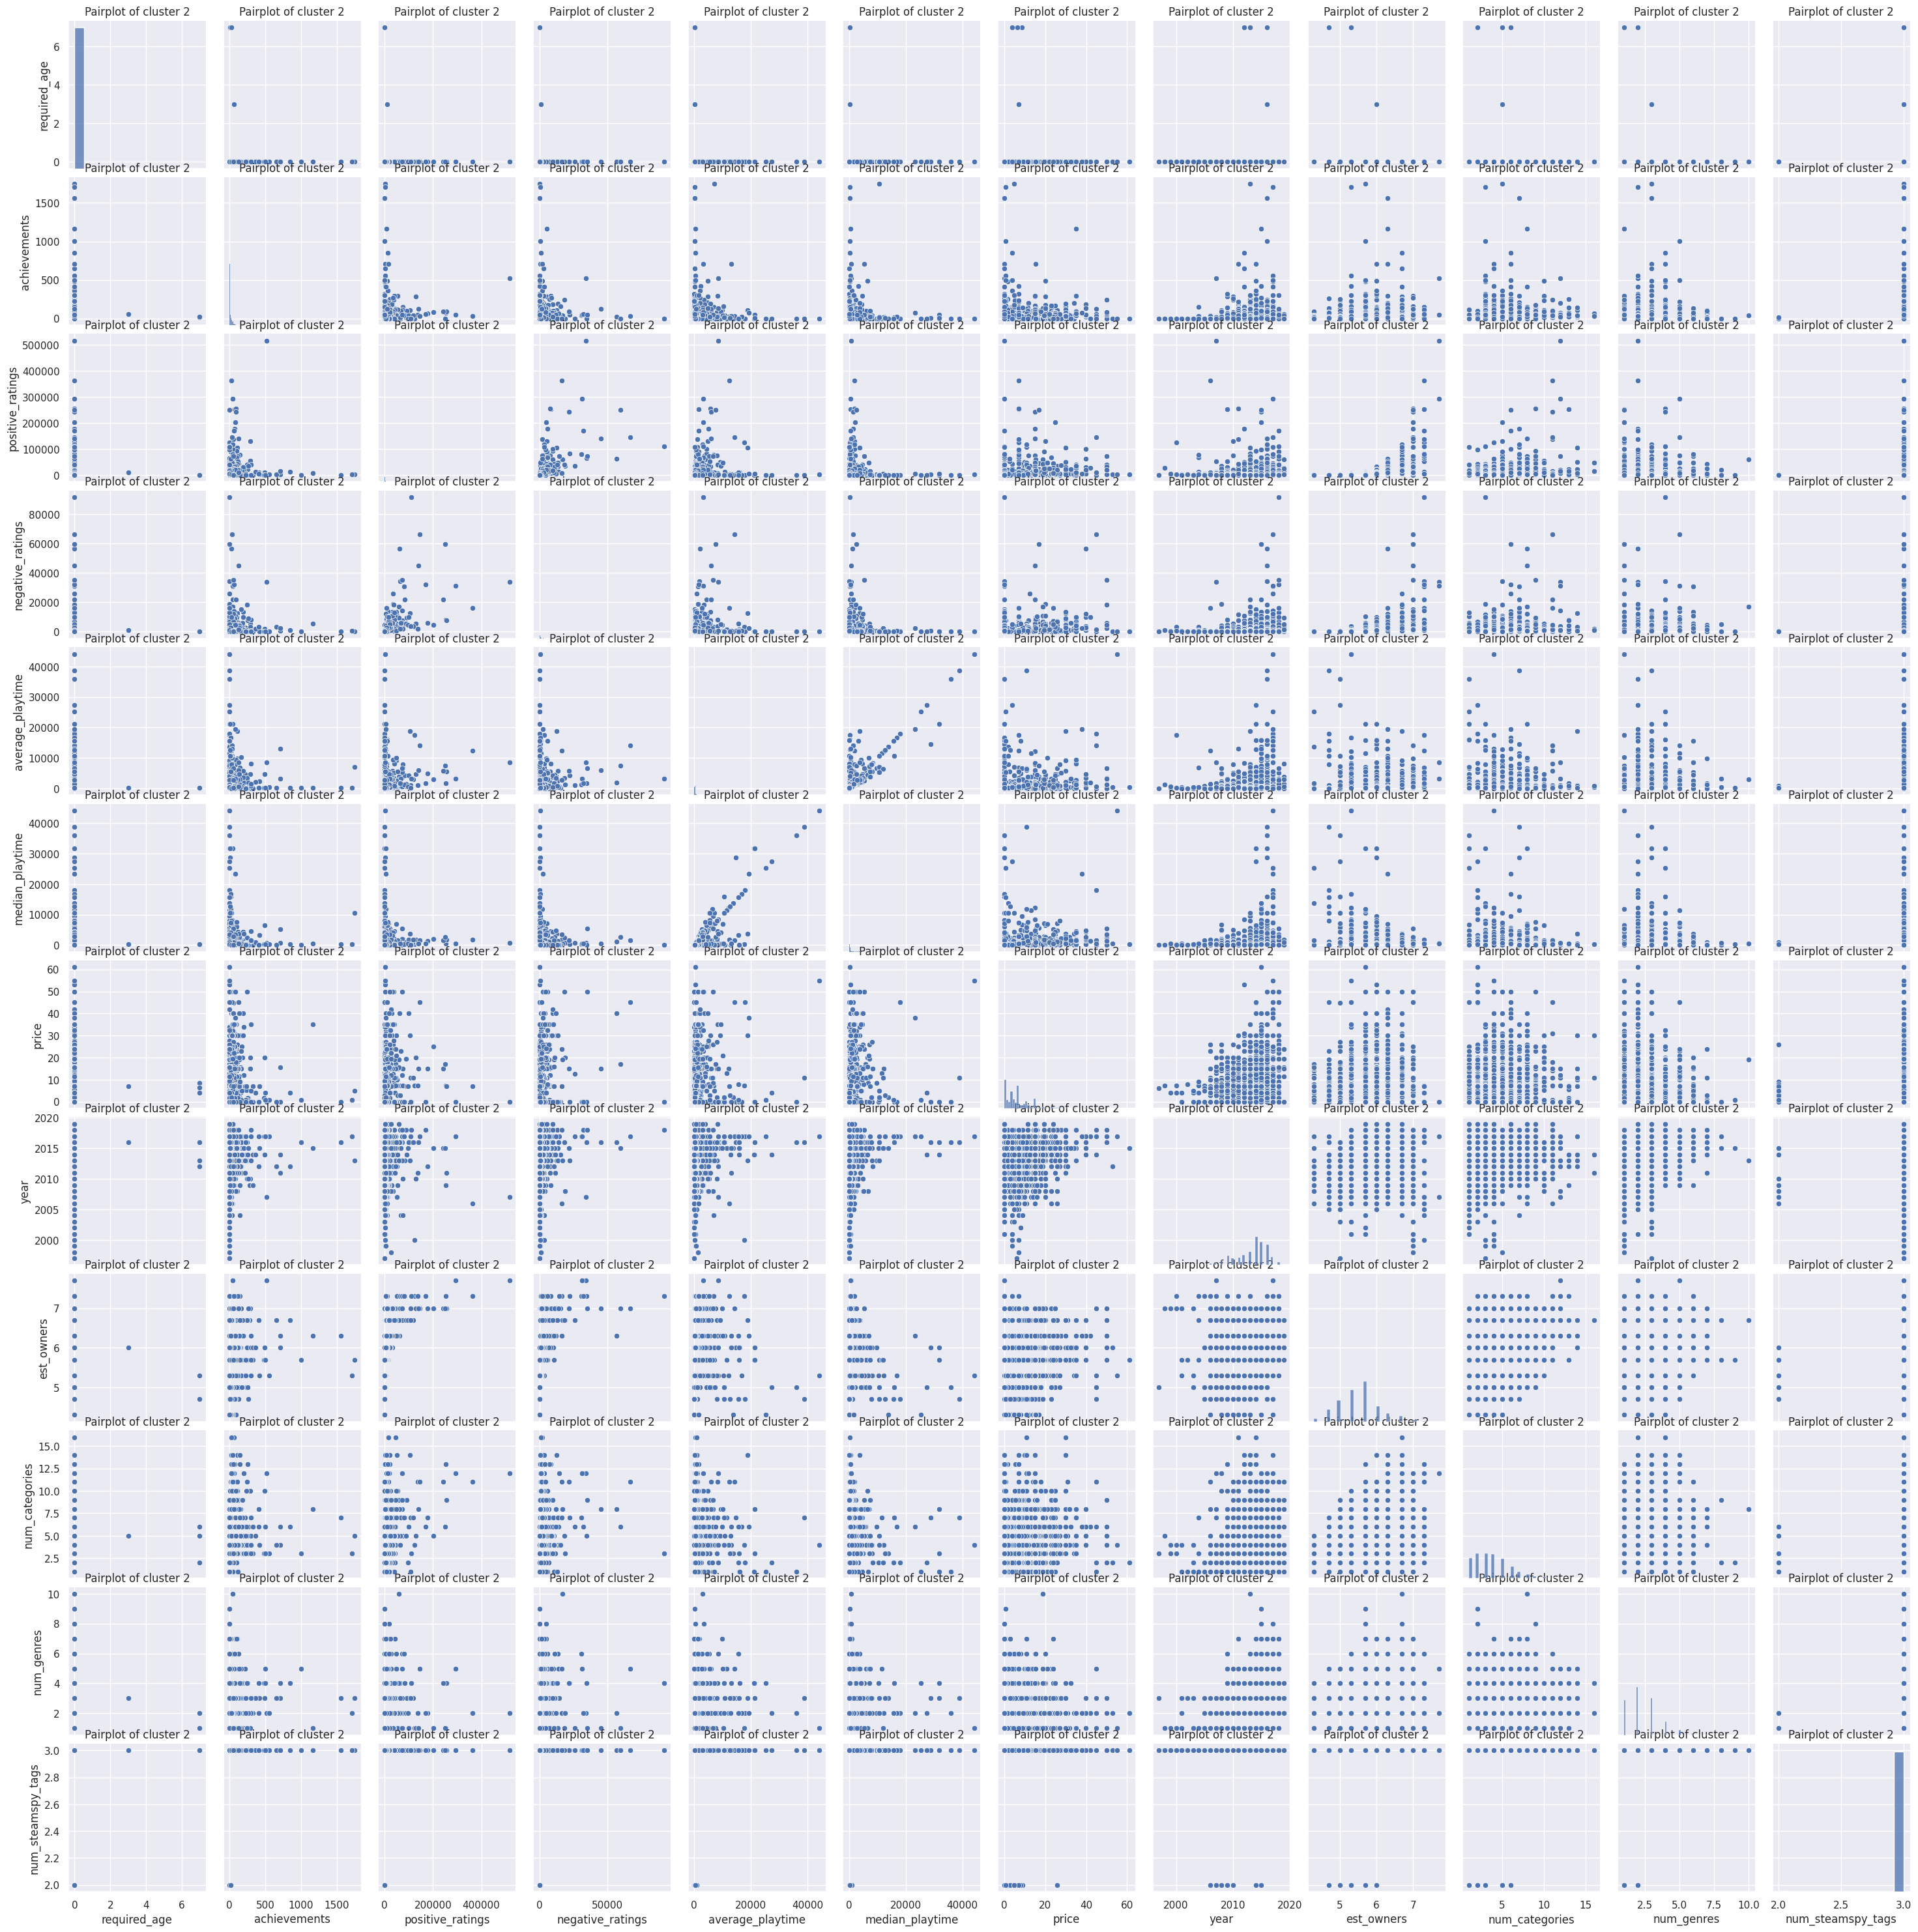

In [79]:
sb.pairplot(kaggle_steam.loc[kaggle_steam['cluster'] == 2][numerical]).set(title='Pairplot of cluster 2')

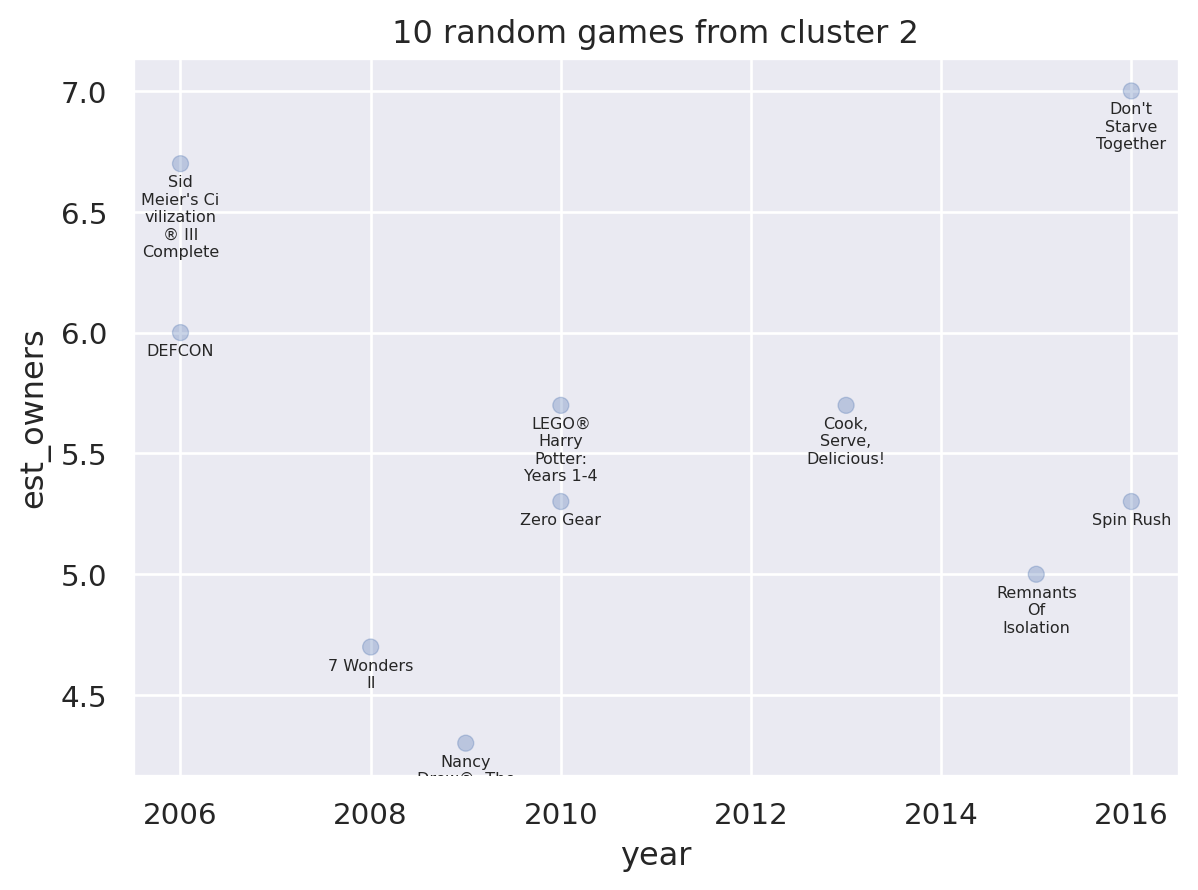

In [136]:
data = kaggle_steam.loc[kaggle_steam['cluster'] == 2].sample(10).copy()
data['name'] = data['name'].str.wrap(10)
(Plot(data, x = 'year', y = 'est_owners', text='name')
 .add(so.Dot(alpha=0.3))
 .add(so.Text(artist_kws={'wrap':True, }, fontsize=6, valign='top'))
 .label(title="10 random games from cluster 2"))

## Cluster 3

The average and median playtimes are the lowest for this cluster. 

Positive Ratings/Negative Ratings 1:2 -> lower than 1:4 on average.

### Remarks
We think these games are usually purchased during a sale/as part of a bundle to more popular games and thus majority players tried them but did not find them fun and rated them poorly.

In [ ]:
c.loc[3, selected_columns].round(2).to_frame().T

,year,achievements,required_age,achievements,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,ratings_ratio,average_playtime,median_playtime,mac,linux,Single-player,Multi-player
3,2016.79,14.27,0.01,14.27,4.4,22800.0,2.19,1.52,1.79,14.2,8.58,1.65,12.91,13.4,0.0,0.0,1.0,0.0


In [ ]:
prop = genres_df.loc[selector].sum().sort_values() / kaggle_steam['cluster'].loc[selector].count()
prop

Accounting               0.000000
Tutorial                 0.000000
Software Training        0.000000
Gore                     0.000000
Game Development         0.000000
Documentary              0.000000
Web Publishing           0.000000
Nudity                   0.000384
Sexual Content           0.000384
Photo Editing            0.000769
Massively Multiplayer    0.001153
Audio Production         0.001538
Video Production         0.001922
Animation & Modeling     0.002307
Education                0.002691
Violent                  0.003460
Design & Illustration    0.004614
Free to Play             0.007305
Utilities                0.013456
Early Access             0.020761
Sports                   0.021146
Racing                   0.027297
RPG                      0.039216
Strategy                 0.103422
Simulation               0.105344
Adventure                0.120723
Action                   0.219146
Casual                   0.333333
Indie                    0.490581
dtype: float64

In [ ]:
selector = kaggle_steam['cluster'] == 3
kaggle_steam[selector].sort_values(by='est_owners', ascending=False).head(30)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,est_owners,linux,mac,windows,num_categories,num_genres,num_steamspy_tags,Single-player,Multi-player,cluster
9873,498320,Trolley Gold,2017-03-17,1,Mantis Games,Displacement Studios,windows,0,Single-player;Steam Achievements;Steam Trading...,Casual;Indie,...,5.69897,0,0,1,3,2,2,1,0,3
2361,267130,Star Swarm Stress Test,2014-01-30,1,Oxide Games,Stardock Entertainment,windows,0,Single-player,Utilities,...,5.69897,0,0,1,1,1,2,1,0,3
14420,627950,1914: Prelude to Chaos,2017-05-08,1,Amaterasu Software,Amaterasu Software,windows,0,Single-player;Steam Trading Cards,RPG,...,5.69897,0,0,1,2,1,2,1,0,3
10006,502090,Invisible Mind,2016-08-10,1,VGstudio,VGstudio,windows,0,Single-player;Steam Trading Cards,Adventure;Indie,...,5.69897,0,0,1,2,2,2,1,0,3
9915,499420,Star Fields,2016-08-06,1,AG media,Back To Basics Gaming,windows,0,Single-player;Steam Trading Cards,Casual;Indie,...,5.69897,0,0,1,2,2,2,1,0,3
2373,267940,Glacier 3: The Meltdown,2014-01-23,1,Team 6 Studios,Funbox Media Ltd,windows,0,Single-player,Action;Racing,...,5.69897,0,0,1,1,2,2,1,0,3
3259,301700,Numba Deluxe,2014-05-23,1,Cobra Mobile,KISS ltd,windows,0,Single-player,Casual,...,5.69897,0,0,1,1,1,2,1,0,3
9023,466790,PixBit,2016-05-21,1,Hipix Studio,Dagestan Technology,windows,0,Single-player;Steam Trading Cards,Action;Indie,...,5.69897,0,0,1,2,2,2,1,0,3
9822,497050,Shape Shifter,2016-07-07,1,PRORTUS,Back To Basics Gaming,windows,0,Single-player;Steam Trading Cards,Casual;Indie,...,5.69897,0,0,1,2,2,2,1,0,3
11074,529920,Resurgence,2017-09-12,1,Lightning Man Media,Lightning Man Media,windows,0,Single-player;Steam Achievements;Steam Trading...,Adventure;Indie,...,5.69897,0,0,1,3,2,2,1,0,3


## Cluster 4

The standout features of these games are the extremely high average_playtime and median_playtime. It is the only one with higer median_playtime than average_playtime. These signify that these game retain their p


### Remarks
Addictive games with endless updates to keep the player base interested and held their player base well. Have a strong following. 

In [ ]:
c.loc[4, selected_columns].round(2).to_frame().T

,year,achievements,required_age,achievements,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,ratings_ratio,average_playtime,median_playtime,mac,linux,Single-player,Multi-player
4,2016.0,17.25,-0.0,17.25,8.23,126000.0,3.5,3.5,3.0,1016.25,284.25,3.58,80140.13,112859.5,1.0,0.0,1.0,0.0


In [ ]:
selector = kaggle_steam['cluster'] == 4
kaggle_steam[selector]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,est_owners,linux,mac,windows,num_categories,num_genres,num_steamspy_tags,Single-player,Multi-player,cluster
1478,219340,The Banner Saga: Factions,2013-02-25,1,Stoic,Versus Evil,windows;mac,0,Multi-player;Cross-Platform Multiplayer,Free to Play;Indie;RPG;Strategy,...,5.69897,0,1,1,2,4,3,0,1,4
2023,252690,Fantasy Grounds,2014-05-09,1,"SmiteWorks USA, LLC","SmiteWorks USA, LLC",windows;mac,0,Multi-player;Co-op;Cross-Platform Multiplayer,Indie;RPG;Strategy,...,4.69897,0,1,1,3,3,3,0,1,4
3930,324510,Boundless,2018-09-11,1,Wonderstruck,Square Enix,windows;mac,0,Multi-player;Online Multi-Player;MMO;Co-op;Onl...,Action;Adventure;Indie;Massively Multiplayer;RPG,...,4.69897,0,1,1,8,5,3,0,1,4
3969,326160,Shroud of the Avatar: Forsaken Virtues,2018-03-27,1,Portalarium,Portalarium,windows;mac;linux,0,Single-player;Multi-player;MMO;Co-op;Cross-Pla...,Free to Play;Massively Multiplayer;RPG,...,5.00000,1,1,1,7,3,3,1,1,4
6014,380140,The Secret of Tremendous Corporation,2015-10-12,1,Sebastian Krzyszkowiak;Konrad Burandt;Paweł Radej,dosowisko.net,windows;linux,0,Single-player;Captions available;Steam Cloud,Adventure;Casual;Free to Play;Indie,...,5.30103,1,0,1,3,4,3,1,0,4
8969,465520,PRICE,2016-09-15,1,YETU GAME,YETU GAME,windows,0,Single-player;Steam Achievements;Steam Trading...,Adventure;Casual;Indie,...,5.69897,0,0,1,3,3,3,1,0,4
9201,474030,The Abbey of Crime Extensum,2016-05-19,1,Manuel Pazos;Daniel Celemín,Manuel Pazos;Daniel Celemín,windows;mac;linux,0,Single-player,Adventure;Free to Play,...,5.00000,1,1,1,1,2,3,1,0,4
23409,892420,懒人修仙传,2018-11-14,0,托更的修罗,托更的修罗,windows,0,Single-player,Casual;Indie;RPG;Simulation,...,4.69897,0,0,1,1,4,3,1,0,4


## Cluster 5

The standout feature of this group is the high number of owners of this game, which about 10^8 users own
There are only 3 games that belong to this cluster.

### Remarks
These games are the esports game. 
These are the only 3 titles in esports that is available on steam. other games like apex legends, league of legends are not available on steam.
They have massive success because of their general appeal to the public. They have great exposure, worldwide tournaments
can play with friends


In [ ]:
c.loc[5, selected_columns].round(2).to_frame().T

,year,achievements,required_age,achievements,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,ratings_ratio,average_playtime,median_playtime,mac,linux,Single-player,Multi-player
5,2014.0,68.0,0.0,68.0,9.0,126000000.0,6.0,2.67,3.0,1334698.33,343822.67,3.88,23125.33,6579.0,1.0,1.0,0.0,1.0


In [ ]:
selector = kaggle_steam['cluster'] == 5
kaggle_steam[selector]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,est_owners,linux,mac,windows,num_categories,num_genres,num_steamspy_tags,Single-player,Multi-player,cluster
22,570,Dota 2,2013-07-09,1,Valve,Valve,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,...,8.30103,1,1,1,7,3,3,0,1,5
25,730,Counter-Strike: Global Offensive,2012-08-21,1,Valve;Hidden Path Entertainment,Valve,windows;mac;linux,0,Multi-player;Steam Achievements;Full controlle...,Action;Free to Play,...,8.00000,1,1,1,8,2,3,0,1,5
12836,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,1,PUBG Corporation,PUBG Corporation,windows,0,Multi-player;Online Multi-Player;Stats,Action;Adventure;Massively Multiplayer,...,8.00000,0,0,1,3,3,3,0,1,5


## Cluster 6

### Remarks

In [ ]:
c.loc[6, selected_columns].round(2).to_frame().T

,year,achievements,required_age,achievements,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,ratings_ratio,average_playtime,median_playtime,mac,linux,Single-player,Multi-player
6,2017.24,15.92,0.0,15.92,4.24,23900.0,2.26,3.14,3.0,55.07,17.15,3.21,19.28,20.73,0.0,0.0,1.0,0.0


## Cluster 7

The standout feature of this group is the extremely high `achievement` count, which belongs into the top >25% percentile. 

### Remarks

This cluster can be the thought of as Steam EXP farmer games as achievements help to level your steam account and completionist games.

In [ ]:
c.loc[7, selected_columns].round(2).to_frame().T

,year,achievements,required_age,achievements,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,ratings_ratio,average_playtime,median_playtime,mac,linux,Single-player,Multi-player
7,2017.5,4741.06,0.0,4741.06,4.41,26800.0,2.42,3.4,2.86,101.18,31.54,3.21,382.87,381.28,0.0,0.0,1.0,0.0


In [ ]:
selector = kaggle_steam['cluster'] == 7
kaggle_steam[selector]['achievements'].describe()

count     139.000000
mean     4741.064748
std       804.205569
min      2448.000000
25%      4984.000000
50%      5000.000000
75%      5000.000000
max      9821.000000
Name: achievements, dtype: float64

In [ ]:
kaggle_steam[selector].sample(10)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,est_owners,linux,mac,windows,num_categories,num_genres,num_steamspy_tags,Single-player,Multi-player,cluster
20548,805680,Star Shield Down,2018-03-01,1,G. Malta,VRS,windows,0,Single-player;Steam Achievements,Action;Casual;Indie;Simulation,...,4.30103,0,0,1,2,4,3,1,0,7
22268,858420,Trivia Vault: Business Trivia,2018-05-17,1,Ripknot Systems,Ripknot Systems,windows,0,Single-player;Steam Achievements,Action;Casual;Simulation,...,4.30103,0,0,1,2,3,3,1,0,7
21697,841860,#Have A Sticker,2018-04-26,1,Red Dolphin Games,VT Publishing,windows,0,Single-player;Steam Achievements,Casual;Strategy,...,4.69897,0,0,1,2,2,3,1,0,7
21280,828150,WIN THE GAME!,2018-04-06,1,AFBIK Studio,AFBIK Studio,windows,0,Single-player;Steam Achievements;Steam Cloud,Action;Casual;Indie,...,4.30103,0,0,1,3,3,3,1,0,7
13169,587830,Archery Practice VR,2017-02-08,1,Virtual Rage Studios LLC,Virtual Rage Studios LLC,windows,0,Single-player;Steam Trading Cards,Action;Adventure;Casual;Indie;RPG,...,5.69897,0,0,1,2,5,3,1,0,7
19772,783600,Kicking Kittens: Putin Saves The World,2018-01-25,1,Virtual Top,VT Publishing,windows,0,Single-player;Steam Achievements,Action;Casual,...,4.30103,0,0,1,2,2,3,1,0,7
13740,604490,Running Through Russia,2017-05-21,1,Spell Helix,Spell Helix,windows;mac;linux,0,Single-player;Steam Achievements,Adventure;Casual;Indie;Early Access,...,5.00000,1,1,1,2,4,3,1,0,7
18711,754120,Ninja Stealth 3,2017-12-06,1,SC Jogos,SC Jogos,windows,0,Single-player;Steam Achievements;Steam Cloud,Casual;Indie;Strategy,...,4.30103,0,0,1,3,3,3,1,0,7
22830,874400,Dinosaur Hunt Puzzle,2018-06-13,1,Racing Bros,ANPA.US,windows;mac;linux,0,Single-player;Steam Achievements;Steam Worksho...,Casual;Free to Play;Indie,...,4.30103,1,1,1,4,3,3,1,0,7
16488,689180,Trivia Vault: 1980's Trivia,2017-08-16,1,Ripknot Systems,Ripknot Systems,windows,0,Single-player;Steam Achievements,Casual;Indie;Simulation;Strategy,...,4.30103,0,0,1,2,4,3,1,0,7
